In [1]:
import numpy,pandas,datetime
import matplotlib,matplotlib.pyplot
import scanpy
scanpy.settings.verbosity=5

# 1. Reading data

In [2]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')
adata=idata.transpose()
print(adata)
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-05-06 11:17:33
AnnData object with n_obs × n_vars = 3477 × 22662 
2019-05-06 11:17:42


# 2. Preprocessing

    normalizing by total count per cell
        finished (0:00:01.04): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


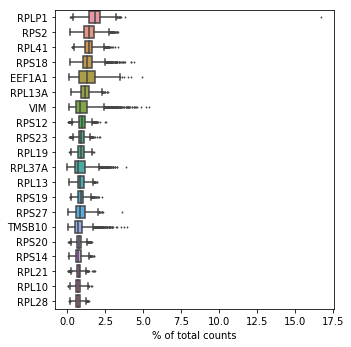

In [3]:
scanpy.pl.highest_expr_genes(adata,n_top=20)

In [4]:
scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)
print(adata)

filtered out 10557 genes that are detected in less than 3 cells
AnnData object with n_obs × n_vars = 3477 × 12105 
    obs: 'n_genes'
    var: 'n_cells'


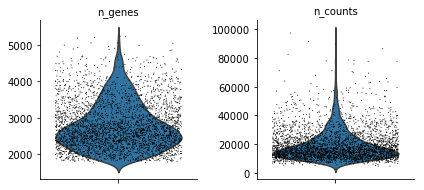

In [5]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
scanpy.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

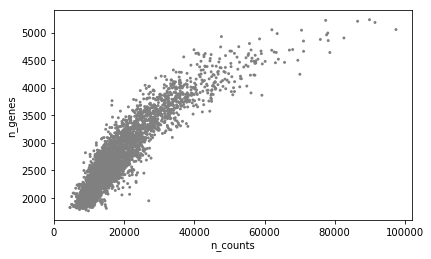

In [6]:
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [7]:
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

    normalizing by total count per cell
        finished (0:00:00.40): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [8]:
adata.raw = adata

    extracting highly variable genes
        finished (0:00:00.61)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


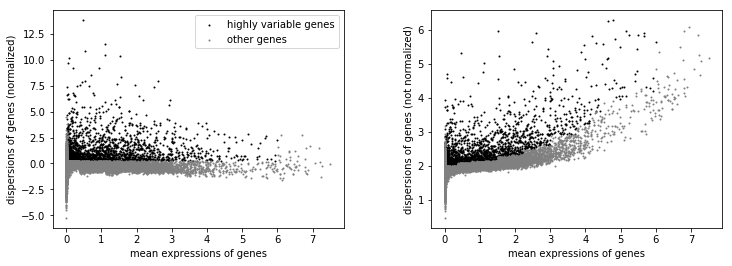

View of AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [9]:
#scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=5.5,min_disp=0.75) # 1,273
#scanpy.pp.highly_variable_genes(adata,min_mean=0.01,max_mean=6,min_disp=0.5) # 1,889
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
#scanpy.pp.highly_variable_genes(adata,min_mean=0,max_mean=8,min_disp=-5) # 12,104
scanpy.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
print(adata)

In [10]:
adata = adata[:, adata.var['highly_variable']]
print(adata)

View of AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [11]:
scanpy.pp.regress_out(adata, ['n_counts'])
scanpy.pp.scale(adata, max_value=10)
print(adata)

regressing out ['n_counts']
    finished (0:00:08.13)
    ... clipping at max_value 10
AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


# 3. Visualization

In [12]:
cellIDs=adata.obs_names.tolist()

dayLabels=[]; uDayLabels=[]
for cellID in cellIDs:
    broken=cellID.split('_M397.')
    dayLabel=broken[1]
    dayLabels.append(dayLabel)
    if dayLabel not in uDayLabels:
        uDayLabels.append(dayLabel) 
print(uDayLabels)
adata.obs['dayLabel']=dayLabels

['control', 'day3', 'day6', 'day13', 'day17', 'day24']


## 3.1. PCA

In [13]:
scanpy.tl.pca(adata, svd_solver='arpack')

    computing PCA with n_comps = 50
        finished (0:00:01.07)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


... storing 'dayLabel' as categorical


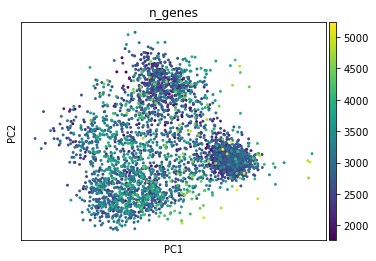

In [14]:
scanpy.pl.pca(adata, color='n_genes')

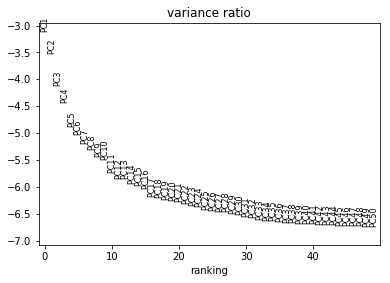

In [15]:
scanpy.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [16]:
#adata.write(resultsFile)
print(adata)

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'dayLabel'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


## 3.2. UMAP

In [61]:
nei=15
scanpy.pp.neighbors(adata, n_neighbors=nei, n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
numberOfClusters=len(adata.obs['louvain'].cat.categories.tolist())

computing neighbors
        initialized `.distances` `.connectivities` 
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.23)
    computed connectivities (0:00:00.63)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished (0:00:04.25) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.22) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [83]:
categories=adata.obs['louvain'].cat.categories.tolist()
ranks=[sum(adata.obs['louvain'].values == str(label)) for label in categories]
standardDeviation=numpy.std(ranks)
accDev=numpy.sum([numpy.abs(rank-int(numpy.mean(ranks))) for rank in ranks])

print(categories)
print(ranks)
print(standardDeviation)
print(accDev)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[570, 569, 367, 340, 323, 313, 276, 264, 234, 221]
119.06473029407155
923


In [86]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
scanpy.settings.verbosity=0

#fine=numpy.concatenate((numpy.arange(5,31,1),numpy.arange(25,105,5)))
#coarse=numpy.arange(200,600,100)
#numberOfNeighbors=numpy.concatenate((fine,coarse))
numberOfNeighbors=numpy.arange(5,31,1)
results=[]

for nei in numberOfNeighbors:
    scanpy.pp.neighbors(adata, n_neighbors=nei, n_pcs=50)
    scanpy.tl.umap(adata)
    scanpy.tl.louvain(adata)
    
    categories=adata.obs['louvain'].cat.categories.tolist()
    ranks=[sum(adata.obs['louvain'].values == str(label)) for label in categories]
    standardDeviation=numpy.std(ranks)
    accDev=numpy.sum([numpy.abs(rank-int(numpy.mean(ranks))) for rank in ranks])
    
    results.append(len(categories))
    
    # print the average number of cells and accumulative deviation from that number
    print(nei,len(categories),int(standardDeviation),accDev)
    
    # store silhouette and cH index
    # redo the stuff in 3D
    
    figureFile='nei.{}.louvain.genes.pdf'.format(nei)
    scanpy.pl.umap(adata, color=['louvain'],palette='Set3',save=figureFile,show=False,title='nei={}'.format(nei))

scanpy.settings.verbosity=5
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-05-06 16:52:07
5 16 129 1625
6 12 151 1381
7 12 101 875
8 11 127 1087
9 11 139 1133
10 10 164 1393
11 11 137 1183
12 10 142 1119
13 10 134 1177
14 10 176 1307
15 10 119 923
16 9 146 1187
17 9 207 1643
18 10 169 1415
19 9 149 1203
20 9 153 1251
21 9 143 1155
22 9 170 1375
23 9 141 1141
24 9 156 1271
25 9 156 1273
26 9 157 1269
27 9 159 1281
28 9 157 1283
29 9 156 1271
30 9 155 1267
2019-05-06 16:54:53


Text(0, 0.5, 'Clusters')

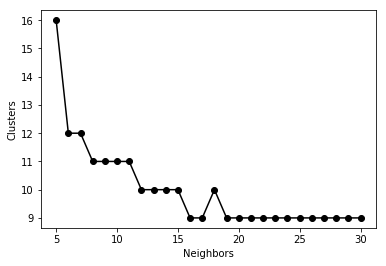

In [85]:
matplotlib.pyplot.plot(numberOfNeighbors,results,'o-',color='black')
matplotlib.pyplot.xlabel('Neighbors')
matplotlib.pyplot.ylabel('Clusters')

## Potting

saving figure to file ./figures/umapdayLabels.genes.pdf


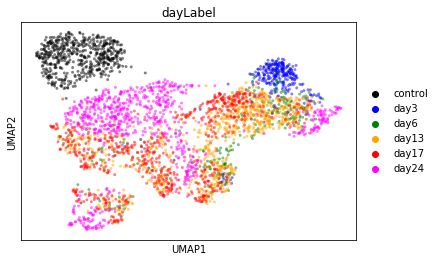

In [20]:
scanpy.pl.umap(adata, color=['dayLabel'],palette=['black','blue','green','orange','red','magenta'],alpha=0.5,save='dayLabels.genes.pdf')

saving figure to file ./figures/umaplouvain.genes.pdf


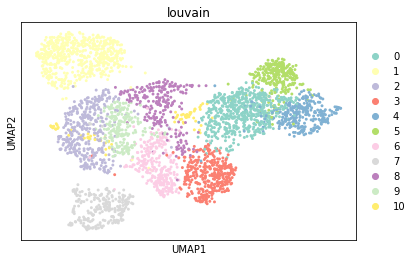

In [21]:
scanpy.pl.umap(adata, color=['louvain'],palette='Set3',save='louvain.genes.pdf')

In [ ]:
dayColors=['grey','blue','green','orange','red','magenta']
positions=adata.obsm['X_umap']
accumulatedDays=[]
for dayLabel in uDayLabels:
    
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(dayColors[accumulatedDays.index(adata.obs['dayLabel'][i])])
            #myColors.append(adata.obs['louvain'][i])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=1/3,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.pdf'.format(tag))
    matplotlib.pyplot.clf()

## Highlighted by day and Louvain membership

In [ ]:
LouvainColors=adata.uns['louvain_colors']
LouvainMemberships=adata.obs['louvain'].tolist()
positions=adata.obsm['X_umap']
accumulatedDays=[]

for dayLabel in uDayLabels:
    
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(LouvainColors[int(LouvainMemberships[i])])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=3/4,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.perDay.LouvainMemberships.pdf'.format(tag))
    matplotlib.pyplot.clf()

In [ ]:
##### non cumulative
LouvainColors=adata.uns['louvain_colors']
LouvainMemberships=adata.obs['louvain'].tolist()
positions=adata.obsm['X_umap']
accumulatedDays=[]
worldColors={}

for dayLabel in uDayLabels:
    
    accumulatedDays=[]
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    worldColors[dayLabel]=[]
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(LouvainColors[int(LouvainMemberships[i])])
            worldColors[dayLabel].append(LouvainColors[int(LouvainMemberships[i])])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=3/4,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.perDay.non.cumulative.LouvainMemberships.pdf'.format(tag))
    matplotlib.pyplot.clf()

f = open("worldColors.txt","w")
f.write( str(worldColors) )
f.close()

In [ ]:
adata.write(resultsFile)

# 4. Marker genes

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
print(pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5))
adata.write(resultsFile)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['0'], n_genes =20)

In [ ]:
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
adata = scanpy.read(resultsFile)
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
scanpy.pl.violin(adata, ['RPS4X', 'SOX10', 'TYMS'], groupby='louvain')

In [ ]:
markerGenes=['RPS4X','SOX10','TYMS','SPARC','RPL31','UQCRB','S100A4','TPM1','RPL37A','ATAD2','CDKN3']
ax = scanpy.pl.dotplot(adata, markerGenes, groupby='louvain')

In [ ]:
ax = scanpy.pl.stacked_violin(adata, markerGenes, groupby='louvain', rotation=90)

In [ ]:
print(adata)

In [ ]:
adata.write_csvs(resultsFile[:-5],skip_data=False)